# Using MLflow
> Log your neuralforecast experiments to MLflow

## Installing dependencies

To install Neuralforecast refer to https://nixtlaverse.nixtla.io/neuralforecast/examples/installation.html.

To install mlflow: `pip install mlflow`

## Imports

In [ ]:
import logging
import warnings

import matplotlib.pyplot as plt
import mlflow
import mlflow.data
import numpy as np
import pandas as pd
from mlflow.client import MlflowClient
from mlflow.data.pandas_dataset import PandasDataset
from utilsforecast.plotting import plot_series

from neuralforecast.core import NeuralForecast
from neuralforecast.models import NBEATSx
from neuralforecast.utils import AirPassengersDF
from neuralforecast.losses.pytorch import MAE

In [ ]:
logging.getLogger("mlflow").setLevel(logging.ERROR)
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

## Splitting the data

In [ ]:
# Split data and declare panel dataset
Y_df = AirPassengersDF
Y_train_df = Y_df[Y_df.ds<='1959-12-31'] # 132 train
Y_test_df = Y_df[Y_df.ds>'1959-12-31'] # 12 test
Y_df.tail()

,unique_id,ds,y
139,1.0,1960-08-31,606.0
140,1.0,1960-09-30,508.0
141,1.0,1960-10-31,461.0
142,1.0,1960-11-30,390.0
143,1.0,1960-12-31,432.0


## MLflow UI
Run the following command from the terminal to start the UI: `mlflow ui`. You can then go to the printed URL to visualize the experiments.

## Model training

In [ ]:
mlflow.pytorch.autolog(checkpoint=False)

with mlflow.start_run() as run:
    # Log the dataset to the MLflow Run. Specify the "training" context to indicate that the
    # dataset is used for model training
    dataset: PandasDataset = mlflow.data.from_pandas(Y_df, source="AirPassengersDF")
    mlflow.log_input(dataset, context="training")

    # Define and log parameters
    horizon = len(Y_test_df)
    model_params = dict(
        input_size=1 * horizon,
        h=horizon,
        max_steps=300,  
        loss=MAE(),
        valid_loss=MAE(),  
        activation='ReLU',
        scaler_type='robust',
        random_seed=42,
        enable_progress_bar=False,
    )
    mlflow.log_params(model_params)

    # Fit NBEATSx model
    models = [NBEATSx(**model_params)]
    nf = NeuralForecast(models=models, freq='M')           
    train = nf.fit(df=Y_train_df, val_size=horizon)
    
    # Save conda environment used to run the model
    mlflow.pytorch.get_default_conda_env()
    
    # Save pip requirements
    mlflow.pytorch.get_default_pip_requirements()

mlflow.pytorch.autolog(disable=True)

# Save the neural forecast model
nf.save(path='./checkpoints/test_run_1/',
        model_index=None, 
        overwrite=True,
        save_dataset=True)

Seed set to 42


## Forecasting the future

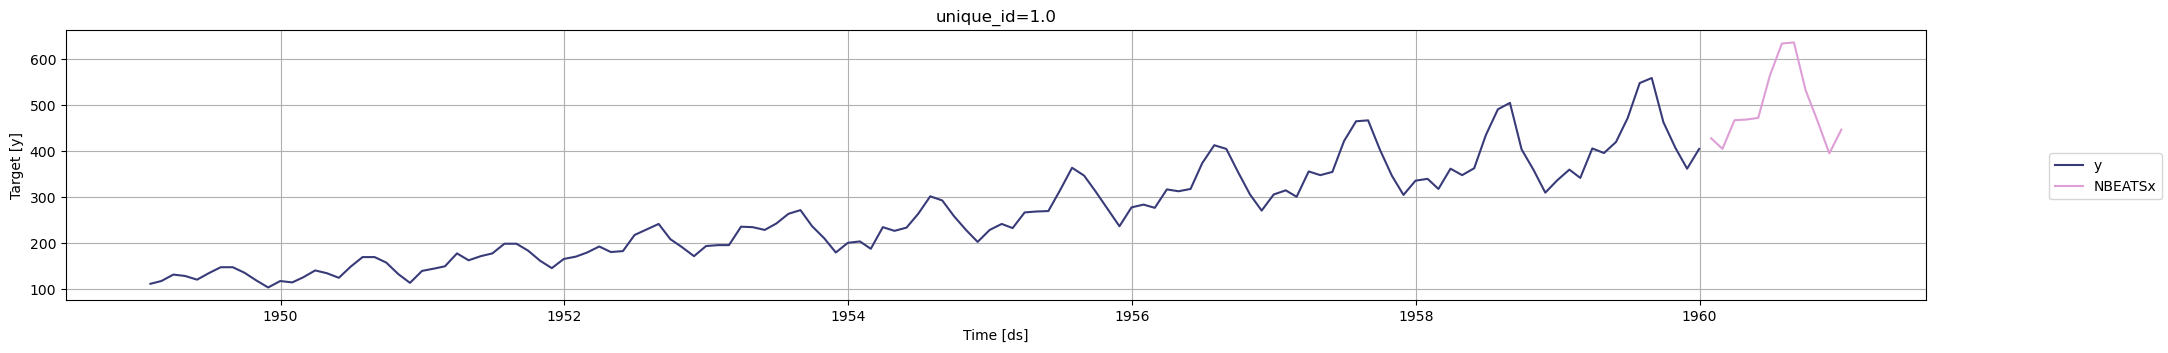

In [ ]:
Y_hat_df = nf.predict(futr_df=Y_test_df)
plot_series(Y_train_df, Y_hat_df, palette='tab20b')